In [118]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import os
from pathlib import Path
import sys
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import datetime as dt

import torch
import torch.nn as nn
import torch.nn.functional as F
tri_path = os.environ.get('TRIPATH_DIR')
if tri_path and tri_path not in sys.path:
    sys.path.append(tri_path)
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from monai.transforms import Resize

In [30]:
data_dir = Path(os.environ['DATA_DIR'])
patch_dir = data_dir / "patches"
paths = list(patch_dir.rglob("*.npy"))

In [31]:
len(paths)

1219

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [106]:
def prepare_data(patch_dir):
    paths = list(patch_dir.rglob("*.npy"))
    patches = [np.load(path) for path in paths]
    patches = torch.stack([torch.from_numpy(patch) for patch in patches])
    patches = patches.float()
    patches = 1 - patches
    patches -= patches.amin(dim=(1, 2, 3), ).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    patches /= patches.amax(dim=(1, 2, 3), ).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    patches = patches.unsqueeze(1)
    targets = [path.parent.name for path in paths]
    return patches, targets

In [140]:
class PatchDataset(Dataset):
    def __init__(self, patches, targets, shape=(16, 16, 16)):
        self.patches = patches
        self.targets = targets
        self.resizer = Resize(spatial_size=shape)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        patch = self.resizer(patch)
        return patch, self.targets[idx]

In [229]:

patches, targets = prepare_data(patch_dir)
le = LabelEncoder()
targets = le.fit_transform(targets)

In [233]:
targets

array([2, 2, 2, ..., 5, 5, 5])

In [230]:
dataset = PatchDataset(patches, targets)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

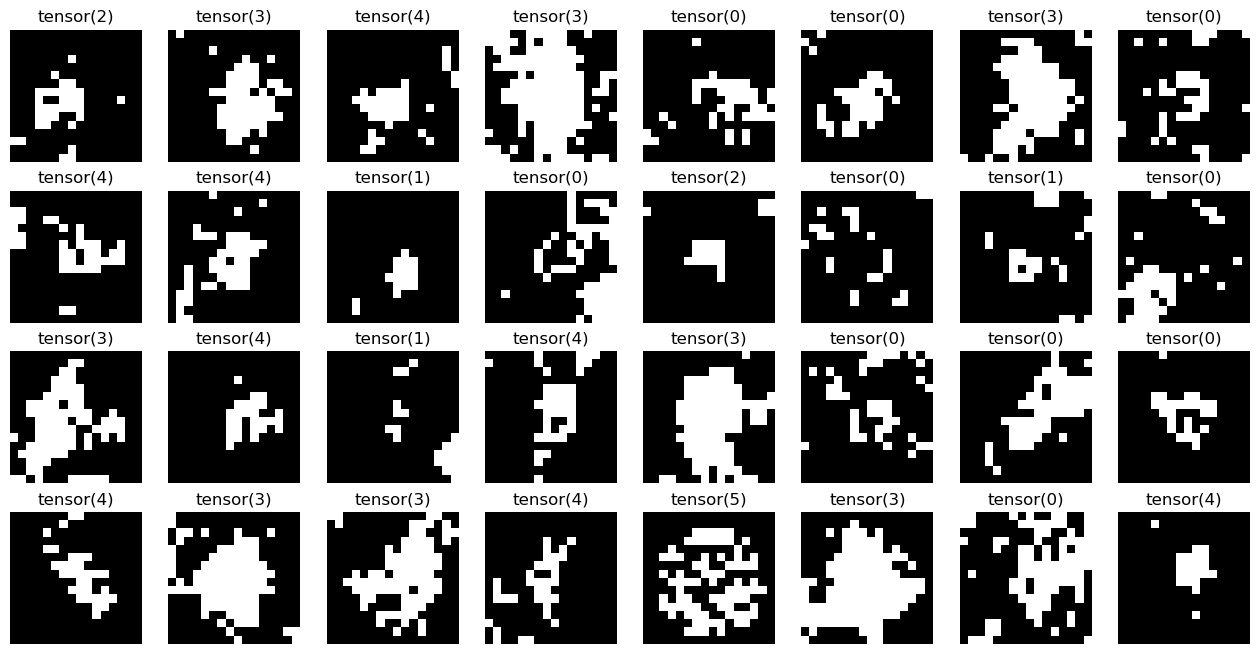

In [232]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
axi = axs.flat
for batch in loader:
    for image, target in zip(*batch):
        plt.sca(next(axi))
        plt.imshow(image[0].max(dim=0)[0] >0.5, cmap="gray")
        plt.title(target)
        plt.axis("off")
    break

In [234]:
images = batch[0]
images.shape

torch.Size([32, 1, 16, 16, 16])

In [235]:
vae = VAE()
print(image.shape)
out = vae.conv1(image)
print(out.shape)
out = vae.conv2(out)
print(out.shape)
out = out.view(-1)
print(out.shape)
out = vae.linear1(out.view(-1))
print(out.shape)
out = vae.mu(out)
print(out.shape)
out = vae.linear2(out)
print(out.shape)
out = vae.linear3(out)
print(out.shape)
out = out.view(32, 3, 3, 3)
print(out.shape)
out = vae.conv3(out)
print(out.shape)
out = vae.conv4(out)
print(out.shape)
out = vae.conv5(out)
print(out.shape)


torch.Size([1, 16, 16, 16])
torch.Size([16, 7, 7, 7])
torch.Size([32, 3, 3, 3])
torch.Size([864])
torch.Size([256])
torch.Size([32])
torch.Size([256])
torch.Size([864])
torch.Size([32, 3, 3, 3])
torch.Size([16, 7, 7, 7])
torch.Size([1, 15, 15, 15])
torch.Size([1, 17, 17, 17])


In [ ]:
class VAE(nn.Module):
    def __init__(self,latent_size=32):
        super(VAE,self).__init__()
        self.latent_size = latent_size

        # For encode # 1,16,16,16
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=2) # 16,7,7,7
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=2) # 32,3,3,3
        self.linear1 = nn.Linear(3*3*3*32, 256) # 256
        self.mu = nn.Linear(256, self.latent_size) # latent_size
        self.logvar = nn.Linear(256, self.latent_size) # latent_size

        # For decoder
        self.linear2 = nn.Linear(self.latent_size, 256) # 256
        self.linear3 = nn.Linear(256,3*3*3*32) 
        self.conv3 = nn.ConvTranspose3d(32, 16, kernel_size=3,stride=2)
        self.conv4 = nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2)
        self.conv5 = nn.ConvTranspose3d(1, 1, kernel_size=3)

    def encoder(self,x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))

        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(device)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 3, 3, 3))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = F.relu(self.conv5(t))
        return t


    def forward(self, x, y):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu,logvar)
        pred = self.decoder(z)
        return pred, mu, logvar


In [237]:
for batch in loader:
    break
model = VAE().to(device)

In [238]:
model(batch[0].to(device), batch[1].to(device))

RuntimeError: ConvTranspose 3D is not supported on MPS

In [ ]:

def loss_function(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, kld


def train(epoch, model, loader, optim):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    for i,(x,y) in enumerate(loader):
        try:
            optim.zero_grad()
            pred, mu, logvar = model(x.to(device),y.to(device))

            recon_loss, kld = loss_function(x.to(device),pred, mu, logvar)
            loss = recon_loss + kld
            loss.backward()
            optim.step()

            total_loss += loss.cpu().data.numpy()*x.shape[0]
            reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
            kld_loss += kld.cpu().data.numpy()*x.shape[0]
            if i == 0:
                print("Gradients")
                for name,param in model.named_parameters():
                    if "bias" in name:
                        print(name,param.grad[0],end=" ")
                    else:
                        print(name,param.grad[0,0],end=" ")
                    print()
        except Exception as e:
            continue

    reconstruction_loss /= len(train_loader.dataset)
    kld_loss /= len(train_loader.dataset)
    total_loss /= len(train_loader.dataset)
    return total_loss, kld_loss,reconstruction_loss


In [ ]:
class VAE3D(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(VAE3D, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv1 = nn.Conv3d(in_channels, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)

        # Compute the flattened size after convolution
        self.fc_input_dim = 128 * 4 * 4 * 4

        # Fully connected layers for the mean and log variance
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.fc_input_dim)
        self.decoder_conv1 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv3 = nn.ConvTranspose3d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        h = F.relu(self.encoder_conv1(x))
        h = F.relu(self.encoder_conv2(h))
        h = F.relu(self.encoder_conv3(h))
        h = h.view(-1, self.fc_input_dim)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_decode(z)).view(-1, 128, 4, 4, 4)
        h = F.relu(self.decoder_conv1(h))
        h = F.relu(self.decoder_conv2(h))
        return torch.sigmoid(self.decoder_conv3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + kld_loss

# Example usage
model = VAE3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Dummy 3D data: batch size of 8, single channel, 3D patch size 32x32x32
# data = torch.randn(8, 1, 32, 32, 32).to(device)
# data = torch.sigmoid(data)

data_dir = Path(os.environ['DATA_DIR'])
patch_dir = data_dir / "patches"
paths = list(patch_dir.rglob("*.npy"))
dataset = PatchDataset(paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training step

for epoch in range(10):
    for batch in tqdm(dataloader):
        model.train()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch[0].to(device))
        loss = vae_loss(recon_batch, batch[0], mu, logvar)
        loss.backward()
        optimizer.step()


    print(f"Training loss: {loss.item()}")

TypeError: PatchDataset.__init__() missing 1 required positional argument: 'targets'

In [22]:
batch[0].shape

torch.Size([32, 1, 32, 32, 32])

In [10]:
data

tensor([[[[[-2.7304e-01,  9.2939e-01, -9.5537e-01,  ...,  1.9967e+00,
             5.2759e-01,  2.7760e-01],
           [-1.2490e+00,  1.4214e+00, -1.1247e+00,  ...,  6.4163e-01,
            -6.7437e-01,  4.6071e-01],
           [ 1.7694e-01,  3.6335e-01, -1.7379e+00,  ..., -1.0350e+00,
             3.6513e-01, -7.6945e-01],
           ...,
           [-1.8044e-01, -2.4234e-01, -1.2156e+00,  ...,  4.2448e-01,
             9.9383e-01, -3.0867e+00],
           [-2.5453e-01,  8.9310e-02, -7.5829e-01,  ..., -6.3213e-01,
             8.4788e-01,  4.6398e-01],
           [-4.6967e-02,  1.5741e+00, -1.5097e-01,  ...,  1.4882e-02,
            -1.6060e-01, -5.5030e-01]],

          [[ 8.4377e-01, -9.9227e-01, -1.3574e+00,  ..., -3.1179e+00,
            -4.7317e-01, -5.8026e-01],
           [-9.8586e-01, -5.4381e-02,  2.2812e-01,  ..., -7.3644e-02,
            -5.9862e-01,  3.2335e-01],
           [ 1.1296e+00, -3.1695e-01, -1.0879e+00,  ..., -1.7826e+00,
             1.7494e+00, -1.4153e+00],
 